This ipynb file serves as the code base for the contiuous optimization project. It was written by Mirjam Brunner and Pascal Kunz.
We first start with datacleaning of the a9a and ijcnn datasets.

In [1]:
import numpy as np


def process_data_a9a(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            # Split the line by whitespace
            elements = line.split()
            try:
                label = int(elements[0])
            except:
                continue
            features = [int(feature.split(':')[0]) for feature in elements[1:]]
            #For some reason, the number of features is not consistent...
            if len(features) != 14:
                continue
            data.append([label] + features)
    return data

def process_data_ijcnn(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            # Split the line by whitespace
            elements = line.split()
            try:
                label = int(elements[0])
            except:
                continue
            features = [float(feature.split(':')[1]) for feature in elements[2:]]
            #For some reason, the number of features is not consistent...
            data.append([label] + features)
    return data



Next, we define the newton algorithms in the following section

In [2]:
import numpy as np
import data_clean as data_clean
import csv


def sigmoid(x):
    '''
    Applies sigmoid function to input
    '''
    return 1 / (1 + np.exp(-x))


def log_loss(y_true, y_pred):
    '''
    Returns Log-loss of y_true and y_pred
    '''
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def log_loss_reg(y, y_pred, w, reg_param=0.001):
    '''
    Returns regularized Log-loss of y_true and y_pred
    '''  
    loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    reg_loss = reg_param * np.sum(w**2/(1+w**2))  # Non-convex regularizer    
    total_loss = loss + reg_loss    
    return total_loss


def compute_lipschitz_constant(f, a, b, num_points=1000):
    """
    Compute the Lipschitz constant of a function f over the interval [a, b].
    """
    # Generate equidistant points within the interval
    x = np.linspace(a, b, num_points)

    # Calculate the absolute difference in function values
    diffs = np.abs(f(x[1:]) - f(x[:-1]))

    # Compute the Lipschitz constant as the maximum difference ratio
    lipschitz_constant = np.max(diffs / (x[1:] - x[:-1]))

    return lipschitz_constant

def gradient(y_true, y_pred, X, w, reg_param=0.001, regularized=False):
    '''
    Computes gradient of log-loss or regularized log-loss
    '''  
    d_reg_loss = (2 * reg_param * w) * (1 / (1 + w**2)**2)  if regularized else 0
    return np.dot(X.T, y_pred - y_true) / len(y_true) + d_reg_loss

def hessian(y_pred, X):
    '''
    returns hessian matrix
    '''
    diag = np.diag(y_pred * (1 - y_pred))
    return np.dot(np.dot(X.T, diag), X) / len(y_pred)

def update_weights(method: str, hess, gradient, weights, H=2, trust_region=[0.2], step_size=0.2, y_true=None, X = None, loss = None, regularized=False):
    '''
    Given a specific newton method, we update the weights differently
    '''
    if method == 'normal_newton':
        weights -= np.dot(np.linalg.inv(hess), gradient)
        return weights
    if method == 'regularized_newton':
        # Method from https://arxiv.org/abs/2112.02089
        weights -= np.dot(np.linalg.inv(hess + np.sqrt(H*np.linalg.norm(gradient)) * np.eye(len(weights))), gradient)
        return weights
    if method == 'linesearch_newton':
        # Line search strategy
        direction = np.dot(np.linalg.inv(hess), gradient)
        for i in range(10):
            new_weights = weights - step_size * direction
            y_pred = sigmoid(np.dot(X, new_weights))
            new_loss = log_loss_reg(y_true, y_pred, new_weights) if regularized else log_loss(y_true, y_pred)
            if new_loss < loss:
                weights = new_weights
                break
            step_size /= 2
        return weights
    elif method == 'trust_region_newton':
        # Solve the trust region subproblem and update weights
        p = solve_trust_region_subproblem(hess, gradient, trust_region[0])
        weights += p
        return weights
    elif method == 'damped_newton':
        #Solve damped_newton method according to https://arxiv.org/pdf/2211.00140.pdf
        #Lipschitz constant of logistic loss = 1 therefore a_k = (-1 + sqrt(1+2||nabla f(x)||))/1*||nabla f(x)||
        weights -= np.dot((-1 + np.sqrt(1+2*np.linalg.norm(gradient)))/np.linalg.norm(gradient) *np.linalg.inv(hess), gradient)
        return weights       
    else:
        raise ValueError("Invalid method specified.")




def solve_trust_region_subproblem(hess, grad, delta):
    """
    Solve the trust region subproblem to obtain the step p.
    """
    # Compute the Newton step
    p = np.linalg.solve(hess + delta * np.eye(len(grad)), -grad)

    # Apply the trust region constraint
    norm_p = np.linalg.norm(p)
    if norm_p <= delta:
        return p
    else:
        return (delta / norm_p) * p



def newton_method(X, y_true, X_test, y_true_test, num_iterations=100, regularized=False, method='normal_newton', H=1):
    # Initialize weights
    num_features = X.shape[1]
    weights = np.zeros(num_features)
    accuracy_list = []
    logloss_list = []

    for _ in range(num_iterations):

        # Calculate predicted probabilities
        y_pred = sigmoid(np.dot(X, weights))
        accuracy, logloss = calculate_accuracy(X_test, weights, y_true_test, regularized=regularized)
        accuracy_list.append(accuracy)
        logloss_list.append(logloss)

        # Calculate gradient and Hessian
        grad = gradient(y_true, y_pred, X, w=weights, regularized=regularized)
        hess = hessian(y_pred, X)
        # Update weights using Newton's method
        weights = update_weights(method, hess, grad, weights, H=H, y_true=y_true, X=X, loss=logloss)    
    return weights, accuracy_list, logloss_list

def calculate_accuracy(X, weights, labels_test, regularized=False):
    # Calculate predicted probabilities for the test dataset using the learned weights
    test_pred_probs = sigmoid(np.dot(X, weights))

    # Apply a threshold to obtain binary predictions (e.g., threshold = 0.5)
    threshold = 0.5
    test_predictions = (test_pred_probs >= threshold).astype(int)

    # Evaluate the predictions using appropriate evaluation metrics (e.g., accuracy, log loss)
    accuracy = np.mean(test_predictions == labels_test)
    logloss = log_loss_reg(labels_test, test_pred_probs, weights) if regularized else log_loss(labels_test, test_pred_probs)
    
    return accuracy, logloss



def run(num_iterations, filepath_train, filepath_test, type, regularized=False, method="normal_newton", H=1):
    if type == "a9a":
        full_dataset = np.array(data_clean.process_data_a9a(file_path=filepath_train))
        full_dataset_test = np.array(data_clean.process_data_a9a(file_path=filepath_test))
    else:
        full_dataset = np.array(data_clean.process_data_ijcnn(file_path=filepath_train))
        full_dataset_test = np.array(data_clean.process_data_ijcnn(file_path=filepath_test))
    
    labels = full_dataset[:, 0]
    labels = np.where(labels == -1, 0, labels)
    X = full_dataset[:, 1:]

    # Add bias term to the feature matrix of the test dataset
    X= np.c_[np.ones(X.shape[0]), X]

    labels_test = full_dataset_test[:, 0]
    labels_test = np.where(labels_test == -1, 0, labels_test)
    X_test = full_dataset_test[:, 1:]

    # Add bias term to the feature matrix of the test dataset
    X_test= np.c_[np.ones(X_test.shape[0]), X_test]


    # Optimize using Newton's method
    weights, accuracy, log_loss = newton_method(X, labels, X_test, labels_test, num_iterations=num_iterations, regularized=regularized, method=method, H=H)
 
    return weights, accuracy, log_loss


# def objective(p, hess, gradient):
#     return  np.dot(p, np.dot(hess, p)) + np.dot(gradient, p)

# def min_qk(weights, hess, gradient, radius):
#     def objective_inner(p):
#         return 0.5*np.dot(p, np.dot(hess, p)) + np.dot(gradient,p) 

#     def constraint(p):
#         return np.linalg.norm(p) -radius


#     result = minimize(objective_inner, np.zeros(len(gradient)), method='SLSQP', constraints={'type': 'ineq', 'fun': constraint})
#     return result.x

# def calculate_pk(s, weights, hess, gradient):
#     return (sigmoid(weights + s) - sigmoid(weights))/(objective(s, hess, gradient))


# def update_trust_region(weights, trust_region, rho, eta1=0.1, eta2=0.9):
#     print(rho)
#     rho = np.linalg.norm(rho)
#     if rho >= eta2:
#         trust_region = 2*trust_region
#         weights = weights + rho
#     elif rho >= eta1:
#         weights = weights + rho
#     else:
#         trust_region = 0.5 * trust_region
#     return trust_region, weights

Now that we have a module for data-cleaning and have defined the actual newton method's we can run some experiments. The following module will run experiments for the methods defined, dataset and number of iterations and store it in a csv file

In [3]:
import csv
import newton
from time import time


def run_experiment(outputfilename, dataset, num_iteration, methods = [], regularized=False, H=2):
    if dataset == "a9a":
        datasetpath = "Datasets/a9a/"
    elif dataset == "ijcnn":
        datasetpath = "Datasets/ijcnn/"
    else:
        return "This dataset does not exist!"
    # Create a CSV file for storing the results
    filename = f"Results/{outputfilename}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Method", "Iteration", "Accuracy", "Log Loss"])

        for method in methods:
            print(method)

            # Run Native Newton's Code for ijcnn dataset
            _, acc, log_loss = newton.run(num_iteration, f'{datasetpath}train.txt', f'{datasetpath}test.txt', type=dataset, method=method, H=H, regularized=regularized)

            # Write the results to the CSV file
            for i in range(len(acc)):
                writer.writerow([method, i+1, acc[i], log_loss[i]])

            print("done")
    print(f"Results saved to Results/{outputfilename}")



Now we can run the experiments by calling the function. Note that this is a computationally expensive task and should not be executred sequentially (and not in a python-notebook for that matter). It takes a loooong time to train all the classifier's for all different methods. The user can play around with this here though (i.e change methods array, regularization parameters etc.

In [5]:
methods = ["damped_newton","normal_newton", "regularized_newton", "linesearch_newton", "trust_region_newton"]
# run_experiment("a9a_regularized", "a9a", 40, methods=methods, regularized=True)
# run_experiment("a9a_unregularized", "a9a", 40,  methods=methods, regularized=False)
# run_experiment("ijcnn_regularized", "ijcnn",  40, methods=methods, regularized=True)
# run_experiment("ijcnn_unregularized", "ijcnn",  40, methods=methods, regularized=False)
run_experiment("a9a_unregularized_2_iterations", "a9a", 2, regularized=False)

Results saved to Results/a9a_unregularized_2_iterations


To save you some time, we have already computed all the result in the Results directory of this repository. You can use the following script to create plots:

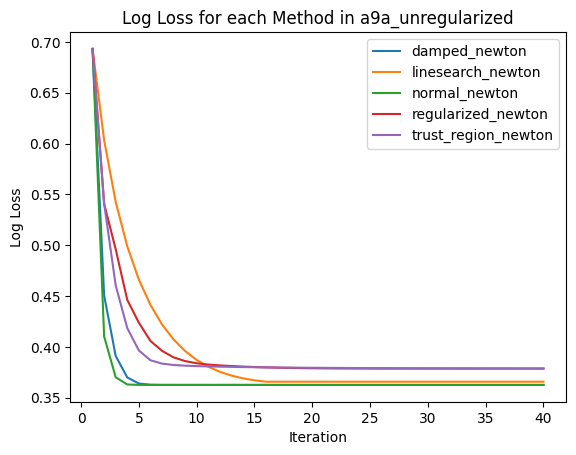

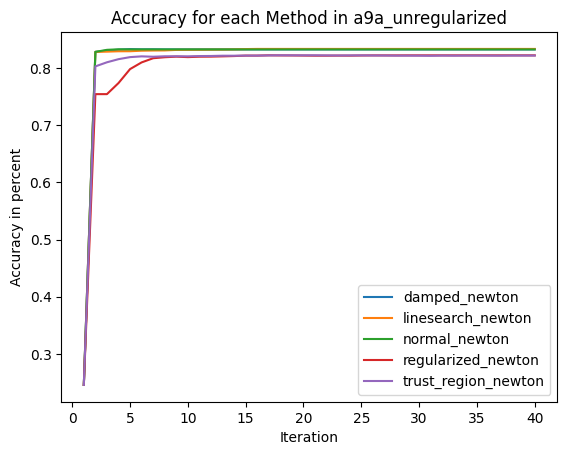

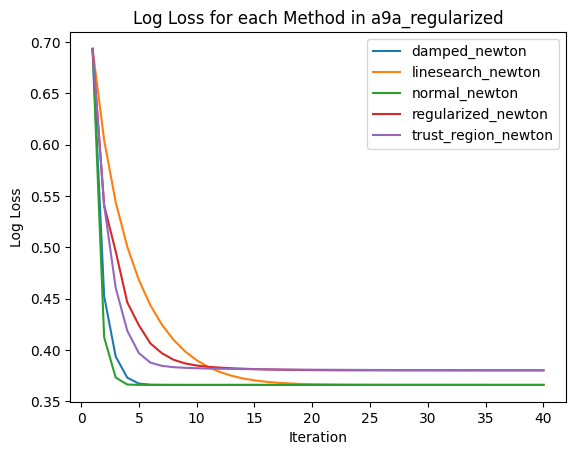

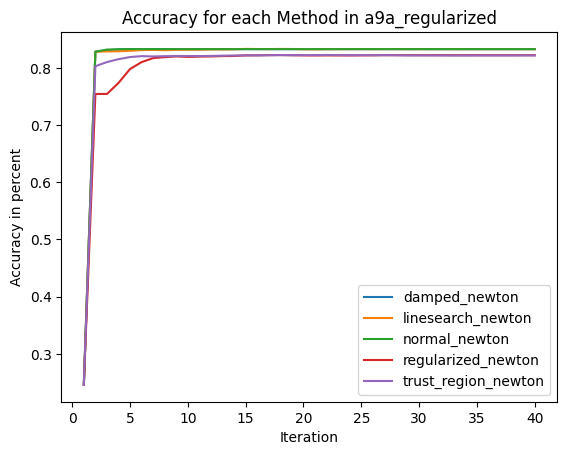

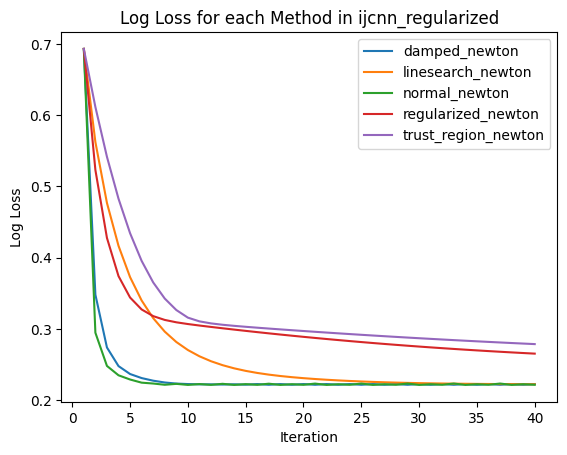

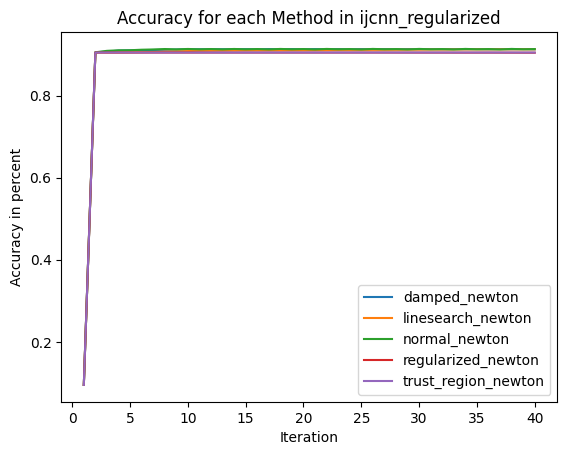

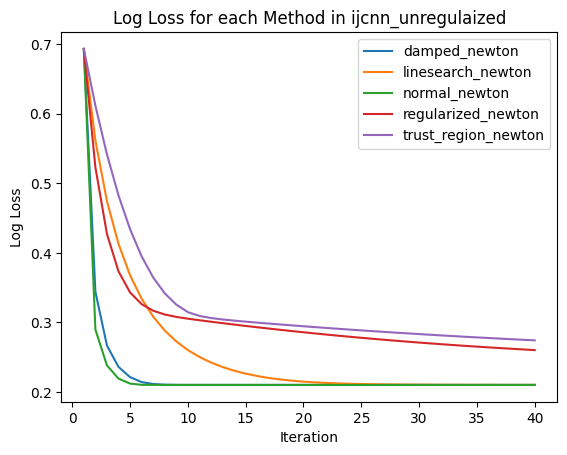

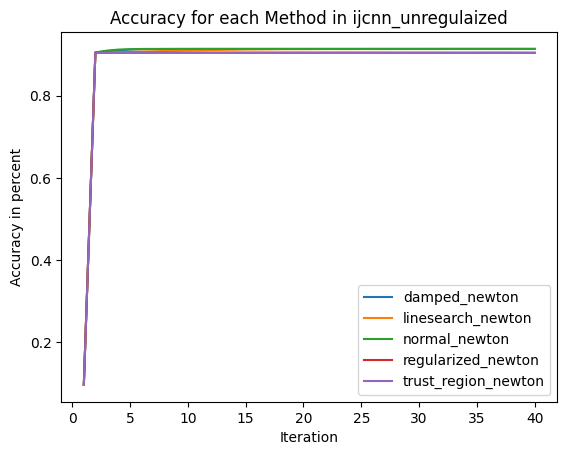

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plotspath = "Plots/"
def plot_data(path):
    # Read the CSV file
    data = pd.read_csv(path)
    filename = path.split('/')[-1].split('.csv')[0]

    # Group the data by method
    grouped_data = data.groupby('Method')


    # Iterate over each group
    for method, group in grouped_data:
        plt.plot(group['Iteration'], group['Log Loss'], label=method)

    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title(f'Log Loss for each Method in {filename}')
    plt.legend()
    plt.savefig(plotspath+f'Log Loss for each Method in {filename}')
    plt.show()
    plt.close()

    # Iterate over each group
    for method, group in grouped_data:
        plt.plot(group['Iteration'], group['Accuracy'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy in percent')
    plt.title(f'Accuracy for each Method in {filename}')
    plt.legend()
    plt.savefig(plotspath+f'Accuracy for each Method in {filename}')
    plt.show()

resultDir = "Results/"
for file in os.listdir("Results"):
    filepath = resultDir + file
    plot_data(filepath)